# Make plots for GAM predictions generated in R

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from settings_general import channel_name_dict
from shared.helper_functions import select_folder, save_figure

Change plot theme

In [2]:
sns.set_theme()

Define palette

In [3]:
palette = {'DRD2-WT': '#419D78', 'DRD2-KO': '#EB5E55'}

### Function definition

In [4]:
def parse_summary_significance(text_filepath, header_line = 'freq window(s) of significant difference(s):\n', end_line = "Summary:\n"):
    """
        Parser for getting significance windows from model report
    """
    
    with open(text_filepath, "r") as f:
        summary = f.readlines()

    # Find header line index
    try:  # if there is no header line, then there are no significant differences
        header_idx = summary.index(header_line)
    except ValueError:
        return pd.DataFrame({})
    
    # find line to stop at
    count = 0
    end_idx = None

    # there are two 'Summary:\n' occurrences, let's find the second
    for i, item in enumerate(summary):
        # Check if the current item is equal to end_line
        if item == end_line:
            # Increment the count of occurrences
            count += 1
            # If it's the second occurrence, store its index and break the loop
            if count == 2:
                end_idx = i
                break

    # Extract the lines containing session_bin windows
    freq_lines = summary[header_idx + 1:end_idx]

    # Extract the numbers from the lines
    numbers = [re.findall(r'([\d.]+)', line) for line in freq_lines]
    return pd.DataFrame(numbers, columns=['from_freq', 'to_freq']).apply(pd.to_numeric)

In [5]:
def plot_gam_lineplots(data, x, y, hue, title, ax, significance_windows=None):
    groups = data[hue].unique()
    
    # loop through genotypes
    for i, group in enumerate(groups):
        # get the genotype data
        df = data[data[hue]==group]
        # plot the line
        ax.plot(df[x], df[y], color=palette[group], label=group)
        ax.fill_between(df[x], df[y] + df['CI'], df[y] - df['CI'], color=palette[group], alpha=0.3)
    
    ax.set_xticks(np.arange(0, 100, 10))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Estimated Power/Frequency (dB/Hz)')
    ax.set_title(title, y=1.01)
    
    if significance_windows is not None:
        ymin = ax.get_ylim()[0]
        ymax = df[y].max() + 0.1 * df[y].max()
        for window in significance_windows.itertuples():
            ax.text(np.floor((window.from_freq + window.to_freq) / 2), ymax, '*', fontweight='bold', fontsize=16)
            ax.hlines(ymax, xmin=window.from_freq, xmax=window.to_freq, color='black', linewidth=2)
            ax.vlines(window.from_freq, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=0.6)
            ax.vlines(window.to_freq, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=0.6)

### Loop model results and plot modeled data

In [6]:
model_results_path = select_folder("Select the folder holding the GAM model output files (summaries & predictions) for this experiment")

In [7]:
plots_folder = select_folder("Select the folder you wish to save plots to")

Let's first plot all data

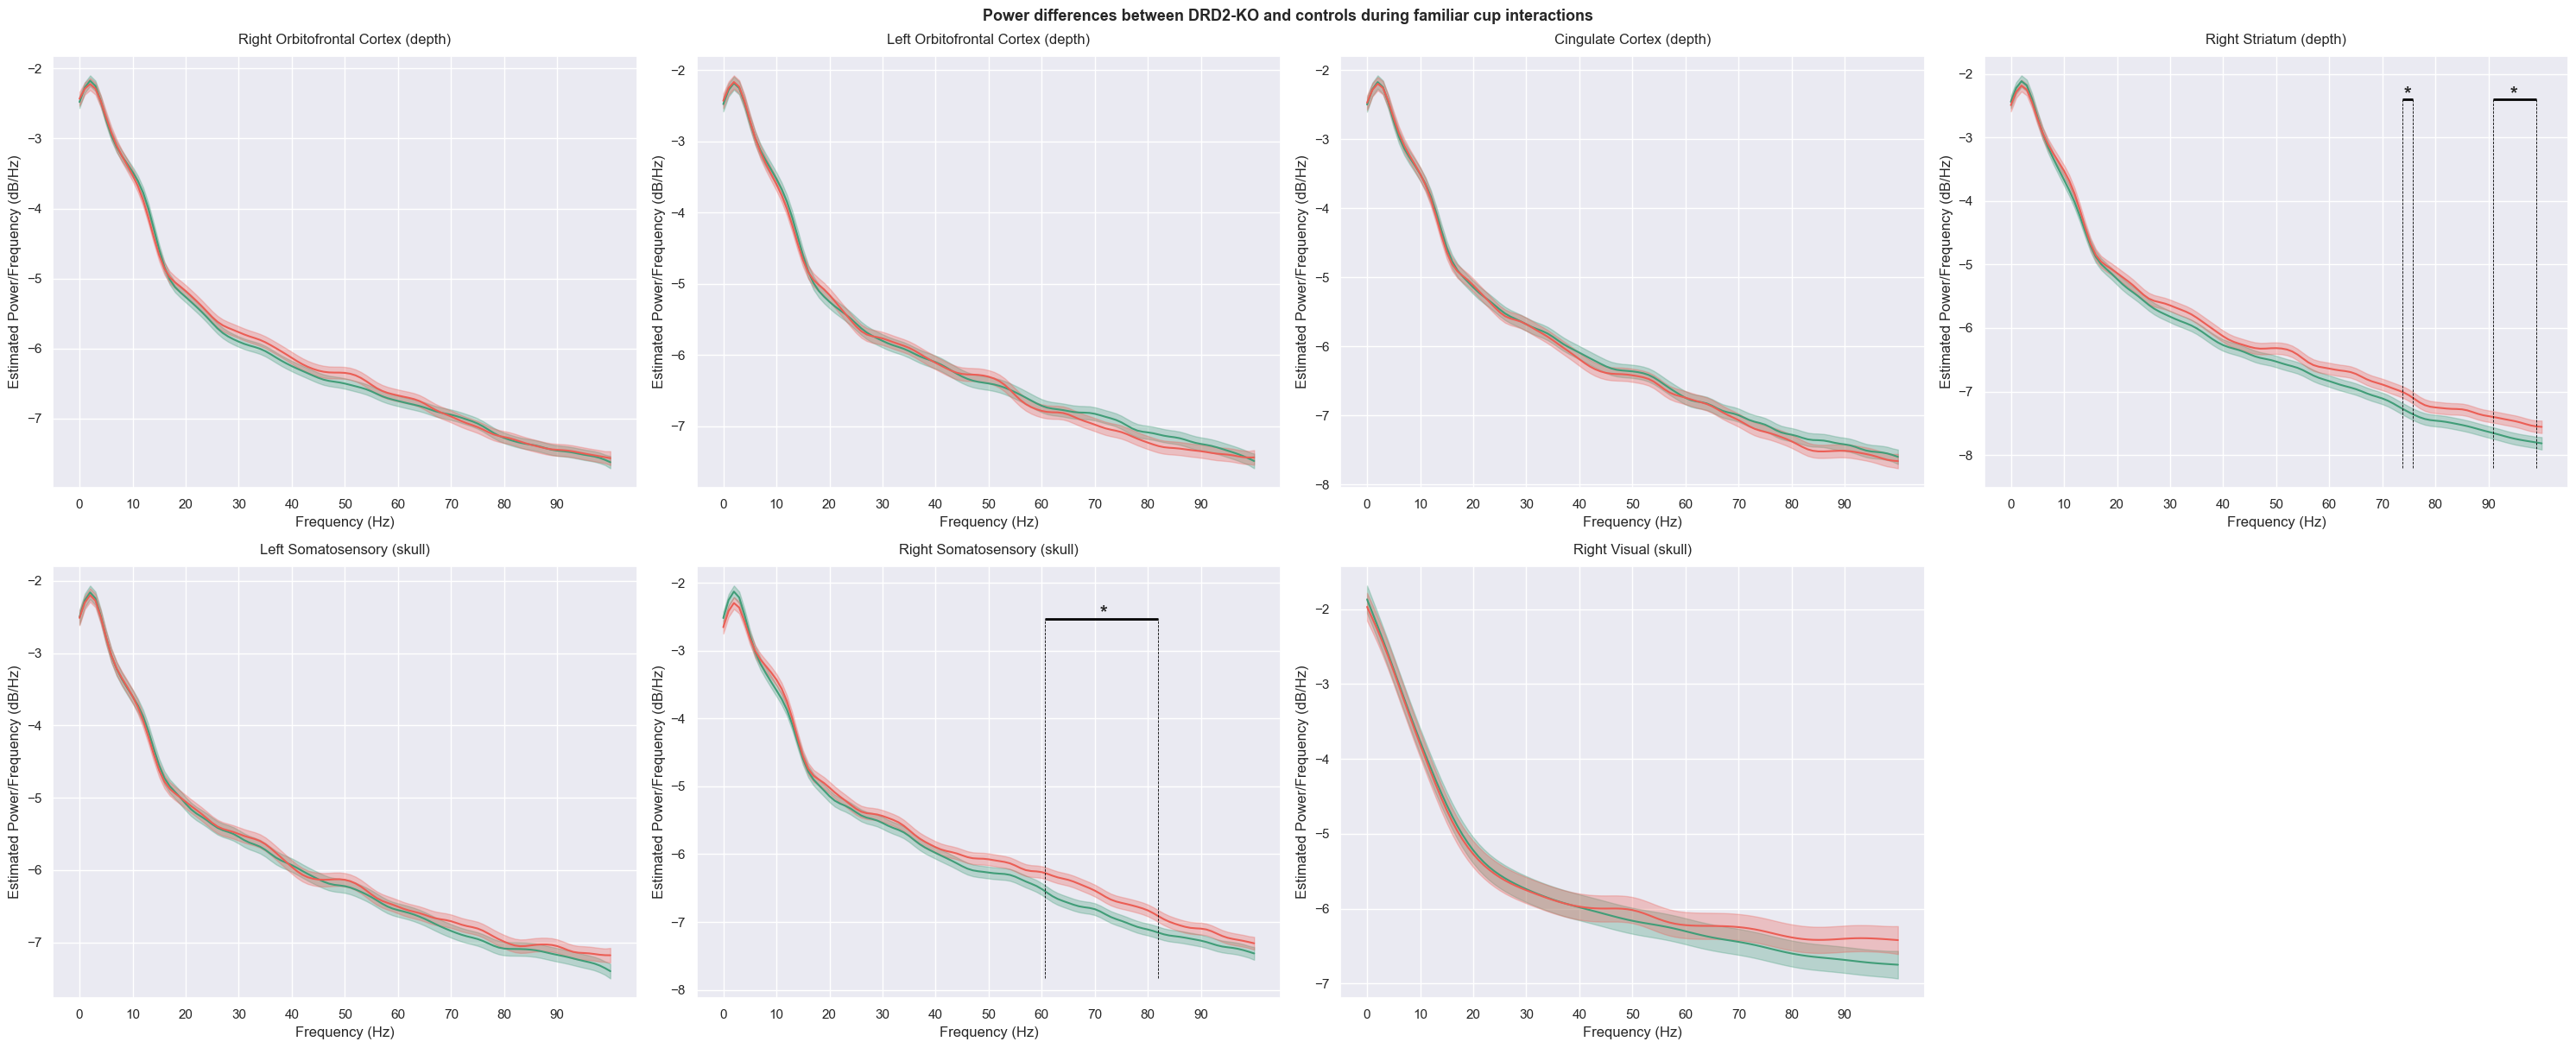

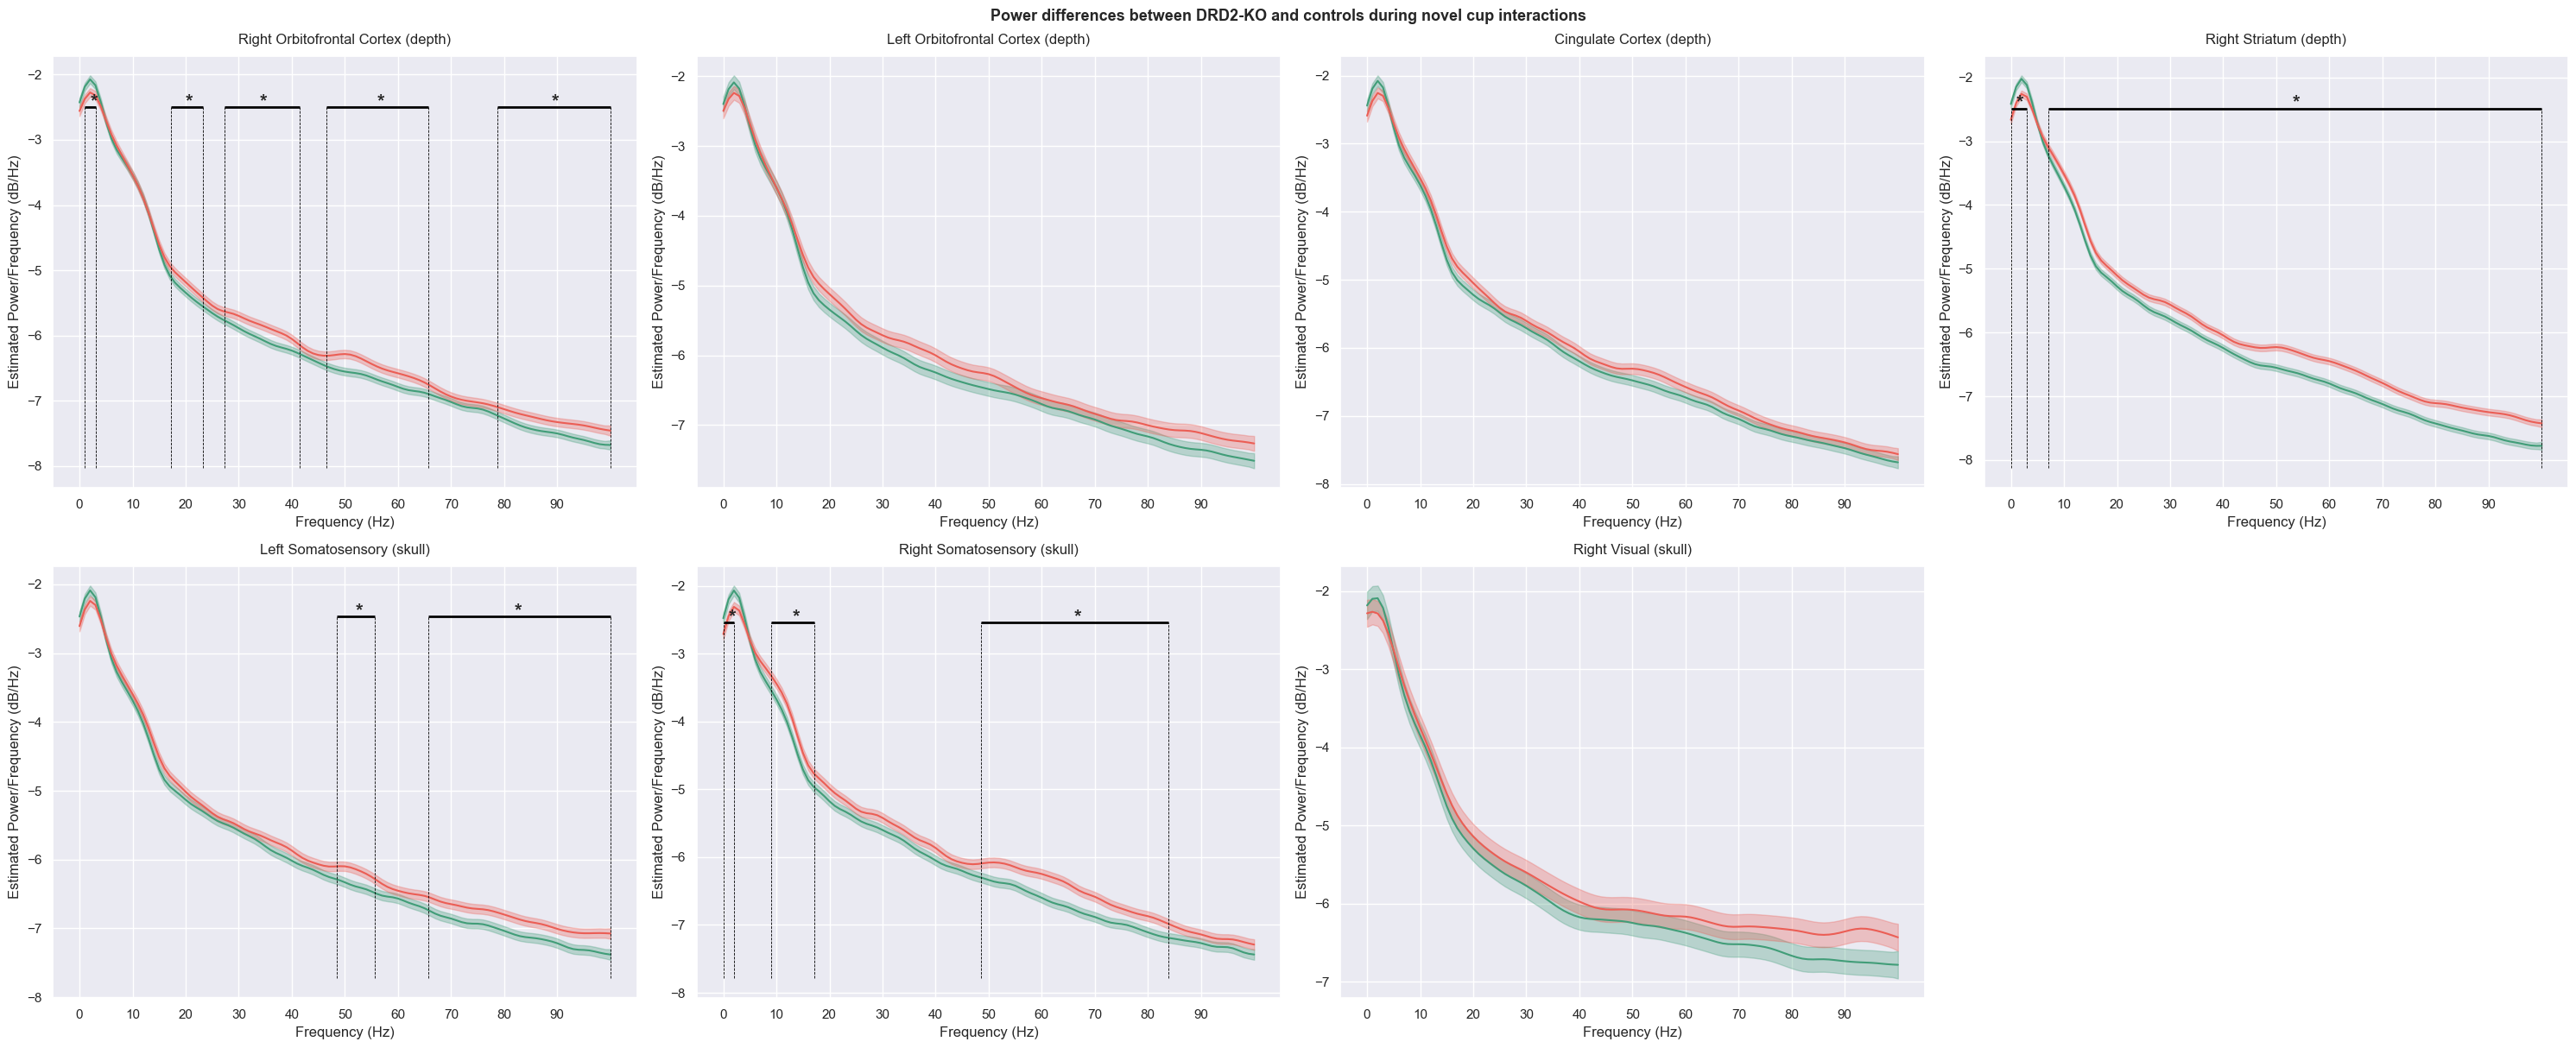

In [8]:
channels = ["OFC_R", "OFC_L", "CG", "STR_R", "S1_L", "S1_R", "V1_R"]
event_types = ["familiar_cup", "novel_cup"]

for event_type in event_types:
    fig, axs = plt.subplots(2, 4, figsize=(30, 12))
    axs = axs.ravel()
    for i, channel in enumerate(channels):
        pred_path = f"{model_results_path}/pred_3_chamber_preference_{event_type}_{channel}.xlsx"  # pred_3_chamber_preference_social_cup_OFC_R
        summary_path = f"{model_results_path}/summary_3_chamber_preference_{event_type}_{channel}.txt"  # summary_3_chamber_preference_social_cup_OFC_R
        try:
            df = pd.read_excel(pred_path)
            sig_win = parse_summary_significance(summary_path)
        except OSError:
            print(f"{pred_path} or {summary_path}, doesnt exist")
            continue
        
        plot_gam_lineplots(df, x="freq", y='fit', hue='genotype', title=channel_name_dict[channel], ax=axs[i], significance_windows=sig_win)
    
    axs[-1].remove()
    plt.tight_layout()
    plt.suptitle(f'Power differences between DRD2-KO and controls during {"familiar cup" if event_type == "familiar_cup" else "novel cup"} interactions', fontsize=13, fontweight='bold', y=1.01)
    save_figure(os.path.join(plots_folder, f'GAMs/{event_type}.pdf'))